In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

print('Modules loaded')


Modules loaded


In [2]:
data_dir = r"D:\CapstoneB\MKN maam\image7500f"
filepaths = []
labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        filepaths.append(file_path)
        label = os.path.basename(root)
        labels.append(label)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
print(df)


                                              filepaths        labels
0     D:\CapstoneB\MKN maam\image7500f\image7500f\No...        Normal
1     D:\CapstoneB\MKN maam\image7500f\image7500f\No...        Normal
2     D:\CapstoneB\MKN maam\image7500f\image7500f\No...        Normal
3     D:\CapstoneB\MKN maam\image7500f\image7500f\No...        Normal
4     D:\CapstoneB\MKN maam\image7500f\image7500f\No...        Normal
...                                                 ...           ...
6995  D:\CapstoneB\MKN maam\image7500f\image7500f\Tu...  Tuberculosis
6996  D:\CapstoneB\MKN maam\image7500f\image7500f\Tu...  Tuberculosis
6997  D:\CapstoneB\MKN maam\image7500f\image7500f\Tu...  Tuberculosis
6998  D:\CapstoneB\MKN maam\image7500f\image7500f\Tu...  Tuberculosis
6999  D:\CapstoneB\MKN maam\image7500f\image7500f\Tu...  Tuberculosis

[7000 rows x 2 columns]


In [3]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
epochs = 10
NUM_CLASSES = 2

def get_callbacks(model_name):
    callbacks = []
    checkpoint = ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_accuracy', mode='max', save_best_only=True)
    callbacks.append(checkpoint)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
    callbacks.append(reduce_lr)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    callbacks.append(early_stopping)
    return callbacks

def build_model():
    base_model = tf.keras.applications.ResNet50(input_shape=img_shape, include_top=False, weights='imagenet')
    base_model.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adamax(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=123)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

g_dict = train_gen.class_indices
classes = list(g_dict.keys())
class_count = len(classes)


Found 5600 validated image filenames belonging to 2 classes.
Found 1400 validated image filenames belonging to 2 classes.


In [5]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

def get_callbacks(model_name):
    callbacks = []
    checkpoint = ModelCheckpoint(filepath=f'model.{model_name}.keras', 
                                 verbose=1, 
                                 monitor='val_accuracy', 
                                 mode='max', 
                                 save_best_only=True)
    callbacks.append(checkpoint)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.2, 
                                  patience=3, 
                                  min_lr=1e-6, 
                                  verbose=1)
    callbacks.append(reduce_lr)
    
    return callbacks


In [6]:
model = build_model()
callbacks = get_callbacks('ResNet50_model')

history = model.fit(train_gen,
                    epochs=epochs,
                    validation_data=test_gen,
                    callbacks=callbacks)


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9581 - loss: 0.0974
Epoch 1: val_accuracy improved from -inf to 0.97714, saving model to model.ResNet50_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 804s 4s/step - accuracy: 0.9582 - loss: 0.0970 - val_accuracy: 0.9771 - val_loss: 0.5220 - learning_rate: 0.0010
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9959 - loss: 0.0120
Epoch 2: val_accuracy did not improve from 0.97714
175/175 ━━━━━━━━━━━━━━━━━━━━ 801s 5s/step - accuracy: 0.9959 - loss: 0.0119 - val_accuracy: 0.6643 - val_loss: 2.5234 - learning_rate: 0.0010
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 1.0000 - loss: 7.1764e-04
Epoch 3: val_accuracy improved from 0.97714 to 0.99286, saving model to model.ResNet50_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 782s 4s/step - accuracy: 1.0000 - loss: 7.1795e-04 - val_accuracy: 0.9929 - val_loss: 0.0193 - learning_rate: 0.0010
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.

In [7]:
ts_length = len(test_df)
test_batch_size = min(32, ts_length)
test_steps = ts_length // test_batch_size

test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)
print(f"Test Loss: ", test_score[0])
print(f"Test Accuracy: ", test_score[1])


43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 836ms/step - accuracy: 0.6061 - loss: 9.5607
Test Loss:  8.725584983825684
Test Accuracy:  0.6155523061752319


In [8]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print("Classification Report")
print(classification_report(test_gen.classes, y_pred, target_names=classes))


44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 854ms/step
Classification Report
              precision    recall  f1-score   support

      Normal       1.00      0.23      0.37       700
Tuberculosis       0.56      1.00      0.72       700

    accuracy                           0.61      1400
   macro avg       0.78      0.61      0.55      1400
weighted avg       0.78      0.61      0.55      1400



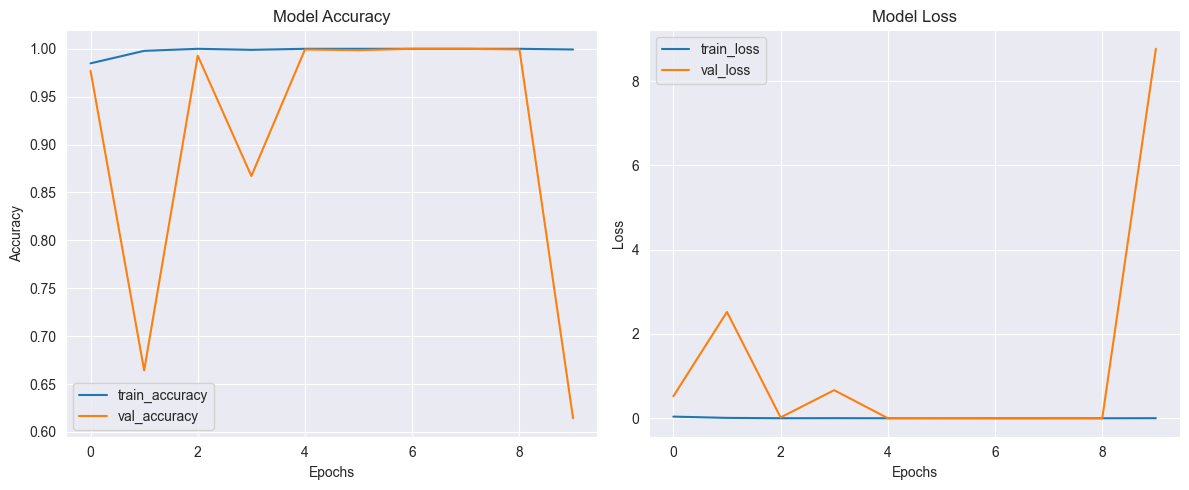

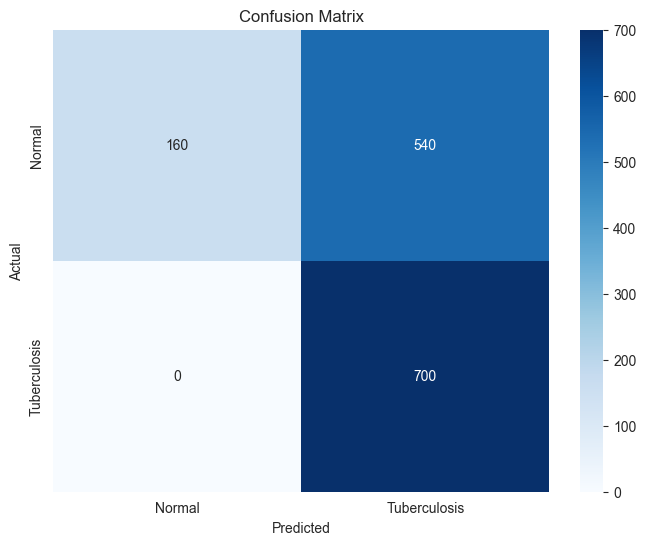

In [9]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(test_gen.classes, y_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [10]:
import tensorflow as tf
import pickle

# Save the model in HDF5 format
model.save(r"D:\CapstoneB\MKN maam\Model\resnet50pre.h5")


In [11]:
model.save("resnet50pre.h5")